<a href="https://colab.research.google.com/github/lululxvi/deepxde/blob/master/examples/Lorenz_inverse_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages (run only once in the runtime)

In [4]:
!pip install deepxde

Imports and functions

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np
import requests

import deepxde as dde
from deepxde.backend import tf


# get training data
def gen_traindata():
    response = requests.get('https://github.com/lululxvi/deepxde/raw/master/examples/dataset/Lorenz.npz')
    response.raise_for_status()
    data = np.load(io.BytesIO(response.content))
    return data["t"], data["y"]

# parameters to be identified
C1 = tf.Variable(1.0)
C2 = tf.Variable(1.0)
C3 = tf.Variable(1.0)

# true values, see p. 15 in https://arxiv.org/abs/1907.04502
C1true = 10
C2true = 15
C3true = 8/3

# define system ODEs
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (28 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]

def boundary(_, on_initial):
    return on_initial

Define data and BCs

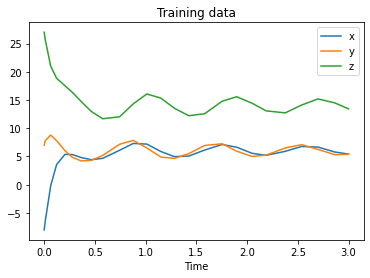

In [3]:
# define time domain
geom = dde.geometry.TimeDomain(0, 3)

# Initial conditions
ic1 = dde.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.IC(geom, lambda X: 27, boundary, component=2)

# Get the training data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

# define data object
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

plt.plot(observe_t, ob_y)
plt.xlabel('Time')
plt.legend(['x','y','z'])
plt.title('Training data')
plt.show()


Train network

In [4]:
# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], 
    period=1,
    filename=fnamevar
)

losshistory, train_state = model.train(epochs=60000, callbacks=[variable])


Compiling model...
Building feed-forward neural network...
'build' took 0.047939 s



/home/bjorn/miniconda3/envs/deepxde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/bjorn/miniconda3/envs/deepxde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-07-15 16:41:52.412555: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-15 16:41:52.458413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-15 16:41:52.458750: I tensorflow/

'compile' took 0.557153 s



2021-07-15 16:41:52.959293: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2304000000 Hz


Initializing variables...
Training model...

> /home/bjorn/code/deepxde/deepxde/model.py(316)_test()
    314             # TODO START HERE TO DECODE. Do so by comparies losses and self.net.outputs in Lorenz.inverse.py
    315             ###
--> 316             self.train_state.loss_train, self.train_state.y_pred_train = self.sess.run(
    317                 [self.losses, self.net.outputs], feed_dict=feed_dict
    318             )

ipdb> c
Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [5.55e-02, 1.22e-01, 8.52e-01, 6.40e+01, 4.90e+01, 7.29e+02, 2.98e+01, 3.50e+01, 2.68e+02]    [5.55e-02, 1.22e-01, 8.52e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
> /home/bjorn/code/deepxde/deepxde/model.py(316)_test()
    314             # TODO START HERE TO DECODE. Do so by comparies losses and self.n

BdbQuit: 

 Plot identified parameters

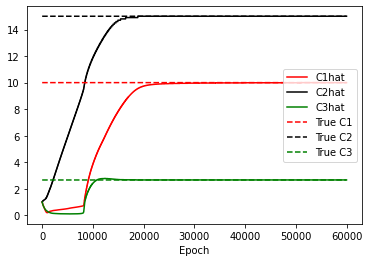

In [8]:
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),Chat[:,2],'g-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'r--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'k--')
plt.plot(range(l),np.ones(Chat[:,2].shape)*C3true,'g--')
plt.legend(['C1hat','C2hat','C3hat','True C1','True C2','True C3'],loc = "right")
plt.xlabel('Epoch')
plt.show()

Predicting...
'predict' took 0.018274 s



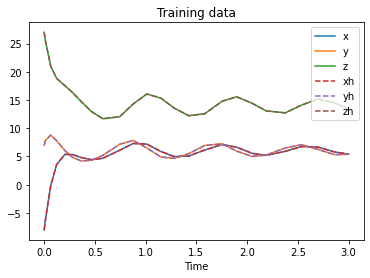

In [9]:
yhat = model.predict(observe_t)

plt.plot(observe_t, ob_y,'-',observe_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['x','y','z','xh','yh','zh'])
plt.title('Training data')
plt.show()